In [1]:
# Main dataset regression (without deduce 0 variance variables)

import pandas as pd
import statsmodels.api as sm

# Load the dataset
final_dataset = pd.read_csv('week5_data/weekly_aggregated_sup_data.csv')

blue_states_list = ['US_CA', 'US_ME', 'US_OR', 'US_CO', 'US_MD', 'US_RI', 'US_CT', 'US_MA', 'US_VT', 'US_DE', 'US_NH', 'US_VA', 'US_DC', 'US_NJ', 'US_WA', 'US_HI', 'US_NM', 'US_NY', 'US_IL']
red_states_list = ['US_AL', 'US_AK', 'US_AR', 'US_ID', 'US_IN', 'US_IA', 'US_KS', 'US_KY', 'US_LA', 'US_MS', 'US_MO', 'US_MT', 'US_NE', 'US_ND', 'US_OK', 'US_SC', 'US_SD', 'US_TN', 'US_TX', 'US_UT', 'US_WV', 'US_WY']

# Set 1 for blue states and 0 for others
final_dataset['blue_states'] = final_dataset['location_key'].apply(lambda x: 1 if x in blue_states_list else 0)

# Set 1 for red states and 0 for others
final_dataset['red_states'] = final_dataset['location_key'].apply(lambda x: 1 if x in red_states_list else 0)

# US_AZ, US_NV, US_FL, US_NC, US_GA, US_OH, US_MI, US_PA, US_MN, US_WI
# Set 1 for swing states and 0 for others
swing_states_list = ['US_AZ', 'US_NV', 'US_FL', 'US_NC', 'US_GA', 'US_OH', 'US_MI', 'US_PA', 'US_MN', 'US_WI']
final_dataset['swing_states'] = final_dataset['location_key'].apply(lambda x: 1 if x in swing_states_list else 0)

# Define the dependent variable
Y = final_dataset['inc cases']

# List of selected variables (assumed after location_key dummies are created)
selected_variables = [
    'new_hospitalized_patients', 
    'new_persons_fully_vaccinated',
    'stringency_index', 
    'average_temperature_celsius', 
    'search_trends_common_cold', 
] + ['blue_states', 'red_states', 'swing_states']  # This includes all dummy variables for location_key

# Fill missing values for the selected numerical columns
for column in selected_variables:
    if column in final_dataset and final_dataset[column].dtype != 'object':
        final_dataset[column].fillna(final_dataset[column].mean(), inplace=True)
        
# Define X with selected variables including dummy variables
X = final_dataset[selected_variables]

# Adding a constant for the intercept
X = sm.add_constant(X)

# Ensure 'y' is numeric and handle missing values
Y = pd.to_numeric(Y, errors='coerce').fillna(Y.mean())

# Fit the OLS model
model = sm.OLS(Y, X).fit()

# Print the summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              inc cases   R-squared:                       0.683
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     1644.
Date:                Tue, 21 May 2024   Prob (F-statistic):               0.00
Time:                        02:29:10   Log-Likelihood:                -68822.
No. Observations:                6104   AIC:                         1.377e+05
Df Residuals:                    6095   BIC:                         1.377e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

                            OLS Regression Results                            
Dep. Variable:              inc cases   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     810.6
Date:                Tue, 21 May 2024   Prob (F-statistic):               0.00
Time:                        02:49:35   Log-Likelihood:                -31624.
No. Observations:                2760   AIC:                         6.327e+04
Df Residuals:                    2751   BIC:                         6.332e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const           

c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


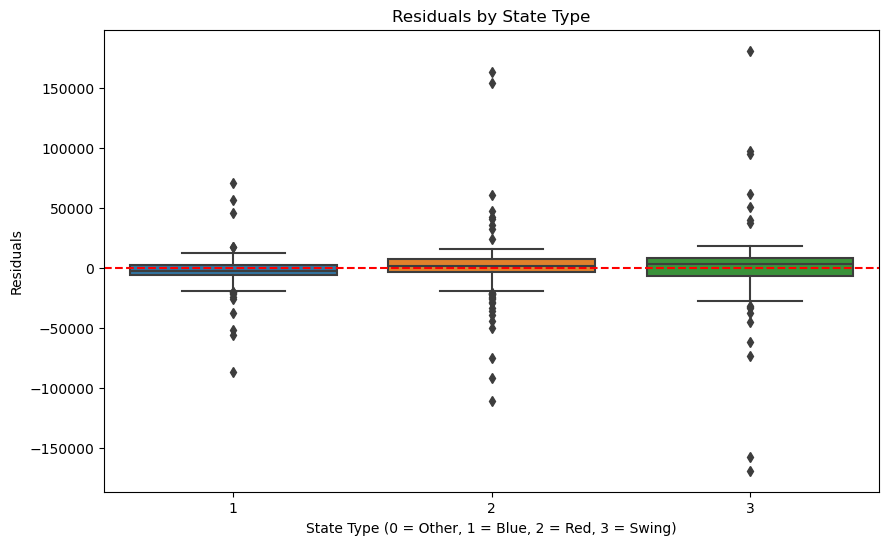

In [5]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

df = pd.read_csv('processed_data/weekly_data_unemployment.csv', low_memory=False)

# Define state lists
blue_states_list = ['US_CA', 'US_ME', 'US_OR', 'US_CO', 'US_MD', 'US_RI', 'US_CT', 'US_MA', 'US_VT', 'US_DE', 'US_NH', 'US_VA', 'US_DC', 'US_NJ', 'US_WA', 'US_HI', 'US_NM', 'US_NY', 'US_IL']
red_states_list = ['US_AL', 'US_AK', 'US_AR', 'US_ID', 'US_IN', 'US_IA', 'US_KS', 'US_KY', 'US_LA', 'US_MS', 'US_MO', 'US_MT', 'US_NE', 'US_ND', 'US_OK', 'US_SC', 'US_SD', 'US_TN', 'US_TX', 'US_UT', 'US_WV', 'US_WY']
swing_states_list = ['US_AZ', 'US_NV', 'US_FL', 'US_NC', 'US_GA', 'US_OH', 'US_MI', 'US_PA', 'US_MN', 'US_WI']

# Create dummy variables for state types
df['blue_states'] = df['location_key'].apply(lambda x: 1 if x in blue_states_list else 0)
df['red_states'] = df['location_key'].apply(lambda x: 1 if x in red_states_list else 0)
df['swing_states'] = df['location_key'].apply(lambda x: 1 if x in swing_states_list else 0)

# Select predictors and target variable before dropping missing values
X = df[['inc cases', 'location_key', 'new_hospitalized_patients', 'new_persons_fully_vaccinated', 'stringency_index', 'average_temperature_celsius', 'search_trends_common_cold', 'unemployment_rate', 'blue_states', 'red_states', 'swing_states']]

# Drop rows with missing values in any selected variable or the target
data_cleaned = X.dropna(axis=0, how='any')

# Separate predictors and target variable after cleaning
y_cleaned = data_cleaned['inc cases']
X_cleaned = data_cleaned.drop(columns=['inc cases'])

# Drop the location_key column as we are using dummy variables for state types instead
X_cleaned = X_cleaned.drop(columns=['location_key'])

# VarianceThreshold with a threshold of 0 (default) to remove 0 variance columns
selector = VarianceThreshold()
X_encoded_var_filtered = selector.fit_transform(X_cleaned)
# Get the columns after variance thresholding
X_encoded_var_filtered = X_cleaned.iloc[:, selector.get_support(indices=True)]

# Calculate the correlation matrix (absolute value - we don't care about direction of correlation)
corr_matrix = X_encoded_var_filtered.corr().abs()

# Select upper triangle of correlation matrix
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Initialize an empty list to keep track of columns to drop
to_drop = []

# Iterate over the columns of the upper triangle
for column in upper_tri.columns:
    for row in upper_tri.index:
        # Check if the correlation is above the threshold and the column hasn't been considered yet
        if upper_tri.loc[row, column] > 0.9 and column not in to_drop and row not in to_drop:
            to_drop.append(column)
            break  # Break the loop once a column is marked for dropping

# 'to_drop' contains columns where only one of each highly correlated pair is considered for dropping

# Drop highly correlated features 
X_encoded_final = X_encoded_var_filtered.drop(columns=to_drop)

# Standardise features to help with interpretation 
scaler = StandardScaler()
scaler.fit(X_encoded_final)
X_train_scaled = pd.DataFrame(scaler.transform(X_encoded_final), columns=X_encoded_final.columns, index=X_encoded_final.index)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, y_cleaned, test_size=0.2, random_state=42)

# Adding a constant for the intercept
X_train_with_const = sm.add_constant(X_train)

# Fitting the linear regression model
model = sm.OLS(y_train, X_train_with_const).fit()

# Displaying the regression results
print(model.summary())

# Perform cross-validation to ensure consistency of the model
cv = KFold(n_splits=5, random_state=42, shuffle=True)
cv_scores = cross_val_score(LinearRegression(), X_train, y_train, cv=cv, scoring='neg_mean_squared_error')
cv_rmse_scores = np.sqrt(-cv_scores)
print(f'Cross-Validation RMSE: {cv_rmse_scores.mean():.4f} (+/- {cv_rmse_scores.std():.4f})')

# Evaluate the model on the test set
X_test_with_const = sm.add_constant(X_test)
y_pred = model.predict(X_test_with_const)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mae = mean_absolute_error(y_test, y_pred)

print(f'Test RMSE: {test_rmse:.4f}')
print(f'Test MAE: {test_mae:.4f}')

# Analyze residuals
residuals = y_test - y_pred
results_df = pd.DataFrame({'Residuals': residuals, 'State_Type': df.loc[y_test.index, 'blue_states'] + df.loc[y_test.index, 'red_states']*2 + df.loc[y_test.index, 'swing_states']*3})

plt.figure(figsize=(10, 6))
sns.boxplot(x='State_Type', y='Residuals', data=results_df)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('State Type (0 = Other, 1 = Blue, 2 = Red, 3 = Swing)')
plt.ylabel('Residuals')
plt.title('Residuals by State Type')
plt.show()


RMSE for Blue States: 12622.0489
RMSE for Red States: 19865.6134
RMSE for Swing States: 30830.0587


c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\kalei\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


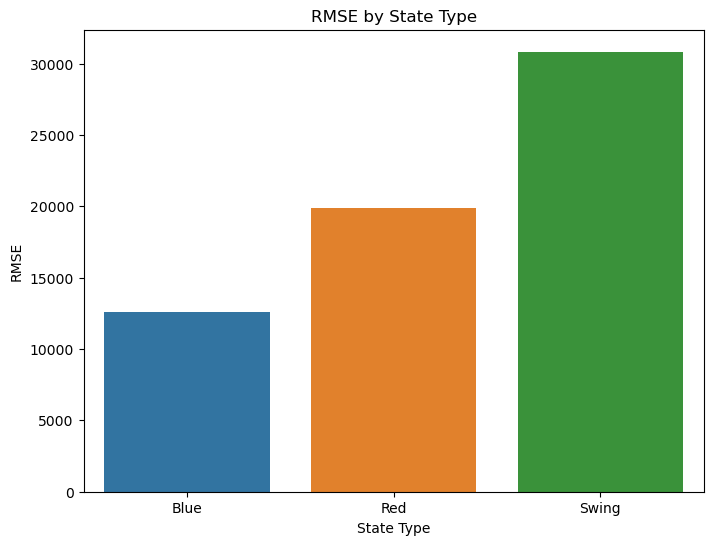

In [6]:
# Evaluate the model on the test set by state type
y_test_blue = y_test[df.loc[y_test.index, 'blue_states'] == 1]
y_test_red = y_test[df.loc[y_test.index, 'red_states'] == 1]
y_test_swing = y_test[df.loc[y_test.index, 'swing_states'] == 1]

X_test_blue = X_test_with_const[df.loc[y_test.index, 'blue_states'] == 1]
X_test_red = X_test_with_const[df.loc[y_test.index, 'red_states'] == 1]
X_test_swing = X_test_with_const[df.loc[y_test.index, 'swing_states'] == 1]

y_pred_blue = model.predict(X_test_blue)
y_pred_red = model.predict(X_test_red)
y_pred_swing = model.predict(X_test_swing)

rmse_blue = np.sqrt(mean_squared_error(y_test_blue, y_pred_blue))
rmse_red = np.sqrt(mean_squared_error(y_test_red, y_pred_red))
rmse_swing = np.sqrt(mean_squared_error(y_test_swing, y_pred_swing))

print(f'RMSE for Blue States: {rmse_blue:.4f}')
print(f'RMSE for Red States: {rmse_red:.4f}')
print(f'RMSE for Swing States: {rmse_swing:.4f}')

# You can also plot these RMSE values for better visualization
rmse_values = pd.DataFrame({
    'State Type': ['Blue', 'Red', 'Swing'],
    'RMSE': [rmse_blue, rmse_red, rmse_swing]
})

plt.figure(figsize=(8, 6))
sns.barplot(x='State Type', y='RMSE', data=rmse_values)
plt.title('RMSE by State Type')
plt.xlabel('State Type')
plt.ylabel('RMSE')
plt.show()
